In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, Dense, Input, Reshape, LSTM, BatchNormalization
from keras.models import Sequential

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from utility_functions import metrics

In [2]:
thesis_dataset = pd.read_csv('data/final_thesis_dataset.csv',parse_dates=[0], index_col=0)

train = thesis_dataset[:6097]
valid = thesis_dataset[6097:7404]
test = thesis_dataset[7404:]

X_solar_train = train[['SWTDN', 'SWGDN', 'T']]
y_solar_train = train['DE_solar_generation_actual']
X_solar_valid = valid[['SWTDN', 'SWGDN', 'T']]
y_solar_valid = valid['DE_solar_generation_actual']
X_solar_test = test[['SWTDN', 'SWGDN', 'T']]
y_solar_test = test['DE_solar_generation_actual']

scaler = StandardScaler()

X_wind_train = scaler.fit_transform(train[['v1', 'v2', 'v_50m', 'z0']])
y_wind_train = scaler.fit_transform(train['DE_wind_generation_actual'].values.reshape(-1,1))
X_wind_valid = scaler.fit_transform(valid[['v1', 'v2', 'v_50m', 'z0']])
y_wind_valid = scaler.fit_transform(valid['DE_wind_generation_actual'].values.reshape(-1,1))
X_wind_test = scaler.fit_transform(test[['v1', 'v2', 'v_50m', 'z0']])
y_wind_test = scaler.fit_transform(test['DE_wind_generation_actual'].values.reshape(-1,1))

In [3]:
model = Sequential()
model.add(Input(shape=(3,)))
model.add(Reshape((-1,1)))
model.add(SimpleRNN(100, activation = 'tanh', input_shape = X_solar_train.shape, return_sequences=False))
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3, 1)              0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               10200     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 20,801
Trainable params: 20,601
Non-trainable params: 200
_________________________________________________________________


In [4]:
model.compile('adam', 'mean_absolute_error', ['accuracy'])

# training
history = model.fit(X_solar_train, y_solar_train, epochs = 20, validation_data = (X_solar_valid, y_solar_valid))

Epoch 1/20
191/191 [==============================] - 5s 14ms/step - loss: 4726.1520 - accuracy: 0.3621 - val_loss: 3147.9526 - val_accuracy: 0.0077
Epoch 2/20
191/191 [==============================] - 1s 4ms/step - loss: 4849.3180 - accuracy: 0.3745 - val_loss: 3124.9668 - val_accuracy: 0.4690
Epoch 3/20
191/191 [==============================] - 1s 3ms/step - loss: 4717.6652 - accuracy: 0.3744 - val_loss: 3108.5952 - val_accuracy: 0.4682
Epoch 4/20
191/191 [==============================] - 1s 3ms/step - loss: 4591.8815 - accuracy: 0.3328 - val_loss: 3051.0193 - val_accuracy: 0.4682
Epoch 5/20
191/191 [==============================] - 0s 2ms/step - loss: 4488.3843 - accuracy: 0.2819 - val_loss: 2954.7065 - val_accuracy: 0.0077
Epoch 6/20
191/191 [==============================] - 0s 2ms/step - loss: 4372.3437 - accuracy: 0.2596 - val_loss: 2980.0339 - val_accuracy: 0.4682
Epoch 7/20
191/191 [==============================] - 1s 3ms/step - loss: 4405.6585 - accuracy: 0.2222 - val_lo

In [5]:
model.evaluate(X_solar_test, y_solar_test)

41/41 [==============================] - 0s 825us/step - loss: 592.2837 - accuracy: 0.0107


[592.28369140625, 0.010711553506553173]

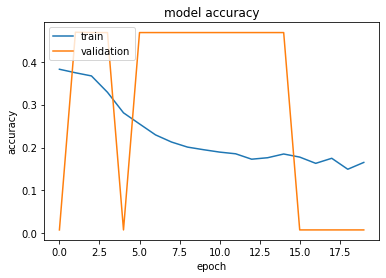

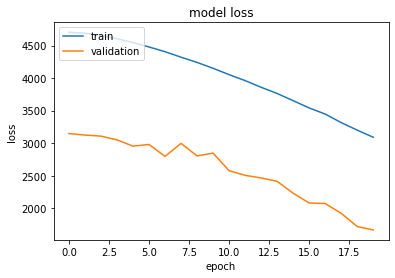

In [6]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [7]:
trainpred = model.predict(X_solar_train)
valpred = model.predict(X_solar_valid)
testpred = model.predict(X_solar_test)

C:\Users\K.N.Dheeraj\anaconda3\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


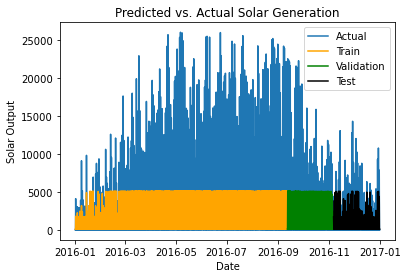

In [8]:
# thesis_dataset = thesis_dataset.reset_index()
df = thesis_dataset[['DE_solar_generation_actual']]

train_df = train[['DE_solar_generation_actual']]
train_df.loc[:, 'DE_solar_generation_actual'] = trainpred

valid_df = valid[['DE_solar_generation_actual']]
valid_df.loc[:, 'DE_solar_generation_actual'] = valpred

test_df = test[['DE_solar_generation_actual']]
test_df.loc[:, 'DE_solar_generation_actual'] = testpred

# # Plot all predictions
inversetransform, =plt.plot(df, label = 'Actual')
trainpredx, =plt.plot(train_df, color='orange', label = 'Train')
valpredx, =plt.plot(valid_df, color='green', label = 'Validation')
testpredx, =plt.plot(test_df, color='black', label = 'Test')
plt.xlabel('Date')
plt.ylabel('Solar Output')
plt.legend(loc="upper right")
plt.title("Predicted vs. Actual Solar Generation")
plt.show()

In [9]:
metrics('drnn', test[['DE_solar_generation_actual']], testpred)

,MAE,MSE,RMSE,RMSLE,R2
model,,,,,
drnn,592.283717,1384.331867,37.206611,3.616486,0.654502


In [10]:
model = Sequential()
model.add(Input(shape=(4,)))
model.add(Reshape((-1,1)))
model.add(SimpleRNN(100, activation = 'tanh', input_shape = X_solar_train.shape, return_sequences=False))
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 4, 1)              0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               10200     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 20,801
Trainable params: 20,601
Non-trainable params: 200
_________________________________________________________________


In [11]:
model.compile('adam', 'mse', ['accuracy'])
history = model.fit(X_wind_train, y_wind_train, validation_data=(X_wind_valid, y_wind_valid), epochs=20)

Epoch 1/20
191/191 [==============================] - 9s 7ms/step - loss: 0.4303 - accuracy: 0.0000e+00 - val_loss: 0.2394 - val_accuracy: 0.0000e+00
Epoch 2/20
191/191 [==============================] - 1s 6ms/step - loss: 0.1192 - accuracy: 0.0000e+00 - val_loss: 0.1049 - val_accuracy: 0.0000e+00
Epoch 3/20
191/191 [==============================] - 1s 4ms/step - loss: 0.1163 - accuracy: 0.0000e+00 - val_loss: 0.1077 - val_accuracy: 0.0000e+00
Epoch 4/20
191/191 [==============================] - 1s 4ms/step - loss: 0.1013 - accuracy: 0.0000e+00 - val_loss: 0.1557 - val_accuracy: 0.0000e+00
Epoch 5/20
191/191 [==============================] - 1s 6ms/step - loss: 0.1167 - accuracy: 0.0000e+00 - val_loss: 0.1200 - val_accuracy: 0.0000e+00
Epoch 6/20
191/191 [==============================] - 2s 9ms/step - loss: 0.1050 - accuracy: 0.0000e+00 - val_loss: 0.1653 - val_accuracy: 0.0000e+00
Epoch 7/20
191/191 [==============================] - 1s 4ms/step - loss: 0.1038 - accuracy: 0.0000e

In [12]:
model.evaluate(X_wind_test, y_wind_test)

41/41 [==============================] - 0s 2ms/step - loss: 0.0878 - accuracy: 0.0000e+00


[0.0878104716539383, 0.0]

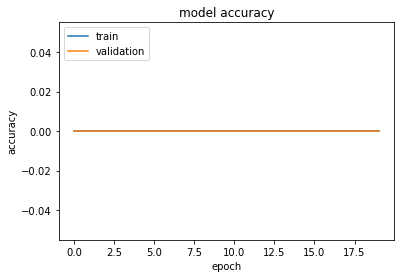

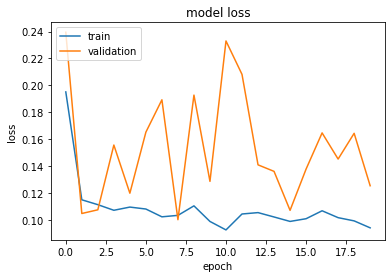

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
trainpred = model.predict(X_wind_train)
valpred = model.predict(X_wind_valid)
testpred = model.predict(X_wind_test)

C:\Users\K.N.Dheeraj\anaconda3\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


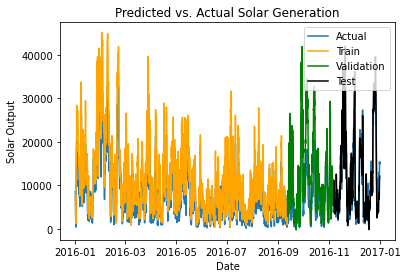

In [15]:
# thesis_dataset = thesis_dataset.reset_index()
df = thesis_dataset[['DE_wind_generation_actual']]

train_df = train[['DE_wind_generation_actual']]
train_df.loc[:, 'DE_wind_generation_actual'] = scaler.inverse_transform(trainpred)

valid_df = valid[['DE_wind_generation_actual']]
valid_df.loc[:, 'DE_wind_generation_actual'] = scaler.inverse_transform(valpred)

test_df = test[['DE_wind_generation_actual']]
test_df.loc[:, 'DE_wind_generation_actual'] = scaler.inverse_transform(testpred)

# # Plot all predictions
inversetransform, =plt.plot(df, label = 'Actual')
trainpredx, =plt.plot(train_df, color='orange', label = 'Train')
valpredx, =plt.plot(valid_df, color='green', label = 'Validation')
testpredx, =plt.plot(test_df, color='black', label = 'Test')
plt.xlabel('Date')
plt.ylabel('Solar Output')
plt.legend(loc="upper right")
plt.title("Predicted vs. Actual Solar Generation")
plt.show()

In [16]:
metrics('drnn', test[['DE_wind_generation_actual']], testpred)

,MAE,MSE,RMSE,RMSLE,R2
model,,,,,
drnn,11903.35948,14710.543403,121.287029,4.79816,-1.895815
